In [ ]:
%%bash
pip install --no-cache-dir -qU pip wheel
pip install --no-cache-dir -qU numpy pandas matplotlib seaborn scikit-learn
pip install --no-cache-dir -qU tensorflow-gpu
pip check

# Using the logs dictionary

In this reading, we will learn how to take advantage of the `logs` dictionary in Keras to define our own callbacks and check the progress of a model.

In [2]:
import os
import numpy as np
import pandas as pd

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style('whitegrid')
sns.set(font='DejaVu Sans')

import tensorflow as tf
tf.keras.utils.set_random_seed(42)
tf.get_logger().setLevel('ERROR')

from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split

The `logs` dictionary stores the loss value, along with all of the metrics we are using at the end of a batch or epoch.

We can incorporate information from the `logs` dictionary into our own custom callbacks.

Let's see this in action in the context of a model we will construct and fit to the `sklearn` diabetes dataset that we have been using in this module.

Let's first import the dataset, and split it into the training and test sets.

In [3]:
# Load the diabetes dataset
diabetes_dataset = load_diabetes()
print(diabetes_dataset['DESCR'])

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - age     age in years
      - sex
      - bmi     body mass index
      - bp      average blood pressure
      - s1      tc, total serum cholesterol
      - s2      ldl, low-density lipoproteins
      - s3      hdl, high-density lipoproteins
      - s4      tch, total cholesterol / HDL
      - s5      ltg, possibly log of serum triglycerides level
      - s6      glu, blood sugar level

Note: Each of these 1

In [4]:
# Save the input and target variables
data = diabetes_dataset['data']
targets = diabetes_dataset['target']

# Split the data set into training and test sets
train_data, test_data, train_targets, test_targets = train_test_split(
    data, targets, test_size=0.1)
print(f"Train data shape: {train_data.shape}")

Train data shape: (397, 10)


Now we construct our model.
We compile the model, with
* Mean squared error as the loss function,
* the Adam optimizer, and
* Mean absolute error (`mae`) as a metric.

In [6]:
def get_model(input_shape):
    """
    Build a sequential model.
    """
    
    # Build the model
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(units=128, activation='relu', 
            input_shape=input_shape),
        tf.keras.layers.Dense(units=64, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(units=64, activation='relu'),
        tf.keras.layers.Dense(units=64, activation='relu'),
        tf.keras.layers.Dense(units=1)
    ])
    # Compile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss=tf.keras.losses.MeanSquaredError(),
        metrics=[tf.keras.metrics.MeanAbsoluteError()]
    )
    return model

# Print the model summary
model = get_model(input_shape=(train_data.shape[1],))
print(model.summary())
print(model.loss)
print(model.optimizer)
print(model.metrics)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 128)               1408      
                                                                 
 dense_6 (Dense)             (None, 64)                8256      
                                                                 
 batch_normalization_1 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 dense_7 (Dense)             (None, 64)                4160      
                                                                 
 dense_8 (Dense)             (None, 64)                4160      
                                                                 
 dense_9 (Dense)             (None, 1)                 65        
                                                      

In [10]:
class PlotHistory():
    plt_nrows = 1
    plt_ncols = 2
    plt_figsize = (15, 5)
    
    def __init__(self, history, metrics=['loss']):
        super().__init__()
        self.history = history
        self.metrics = metrics
        
    @classmethod
    def _create_plot(cls):
        return plt.subplots(nrows=cls.plt_nrows,
            ncols=cls.plt_ncols, figsize=cls.plt_figsize)
    
    def plot(self):
        df_history = pd.DataFrame(self.history.history,
            index=self.history.epoch)
        fig, axes = self._create_plot()
        for ax, metric in zip(axes, self.metrics):
            sns.lineplot(ax=ax, data=df_history,
                x=df_history.index+1, y=metric, label='train')
            try:
                sns.lineplot(ax=ax, data=df_history,
                    x=df_history.index+1, y=f'val_{metric}',
                    label='valid')
            except Exception:
                pass
            ax.legend(loc='best')
            ax.set_xlabel('epoch')
            ax.set_ylabel(f'{metric}')
            ax.set_title(f'{metric} vs. epoch')
        fig.tight_layout()
        plt.show()

### Defining a custom callback

Now we define our custom callback using the `logs` dictionary to access the loss and metric values.

In [7]:
# Create the custom callback

class LossAndMetricCallback(tf.keras.callbacks.Callback):
    
    # Print the loss after every second batch in the training set
    def on_train_batch_end(self, batch, logs=None):
        if batch%2==0:
            print('\n After batch {}, the loss is {:7.2f}.'.format(
                batch, logs['loss']))
            
    # Print the loss after each batch in the test set
    def on_test_batch_end(self, batch, logs=None):
        print('\n After batch {}, the loss is {:7.2f}.'.format(
            batch, logs['loss']))
        
    # Print the loss and mean absolute error after each epoch
    def on_epoch_end(self, epoch, logs=None):
        print('Epoch {}: Average loss is {:7.2f}, mean absolute error is {:7.2f}'.format(
            epoch, logs['loss'], logs['mean_absolute_error']))
        
    # Notify the user when prediction has finished on each batch
    def on_predict_batch_end(self, batch, logs=None):
        print('Finished prediction on batch {}!'.format(batch))

We now fit model to the data, and specify that we would like to use our custom callback `LossAndMetricCallback()`.


 After batch 0, the loss is 32587.72.

 After batch 2, the loss is 28358.99.
Epoch 0: Average loss is 28984.47, mean absolute error is  151.91

 After batch 0, the loss is 29834.02.

 After batch 2, the loss is 29100.21.
Epoch 1: Average loss is 28856.51, mean absolute error is  151.53

 After batch 0, the loss is 27904.28.

 After batch 2, the loss is 28695.09.
Epoch 2: Average loss is 28688.65, mean absolute error is  151.02

 After batch 0, the loss is 29617.11.

 After batch 2, the loss is 28943.45.
Epoch 3: Average loss is 28446.58, mean absolute error is  150.27

 After batch 0, the loss is 32167.87.

 After batch 2, the loss is 28202.80.
Epoch 4: Average loss is 28116.42, mean absolute error is  149.25

 After batch 0, the loss is 28722.11.

 After batch 2, the loss is 27739.17.
Epoch 5: Average loss is 27629.73, mean absolute error is  147.78

 After batch 0, the loss is 30689.38.

 After batch 2, the loss is 27807.34.
Epoch 6: Average loss is 27014.54, mean absolute error is 

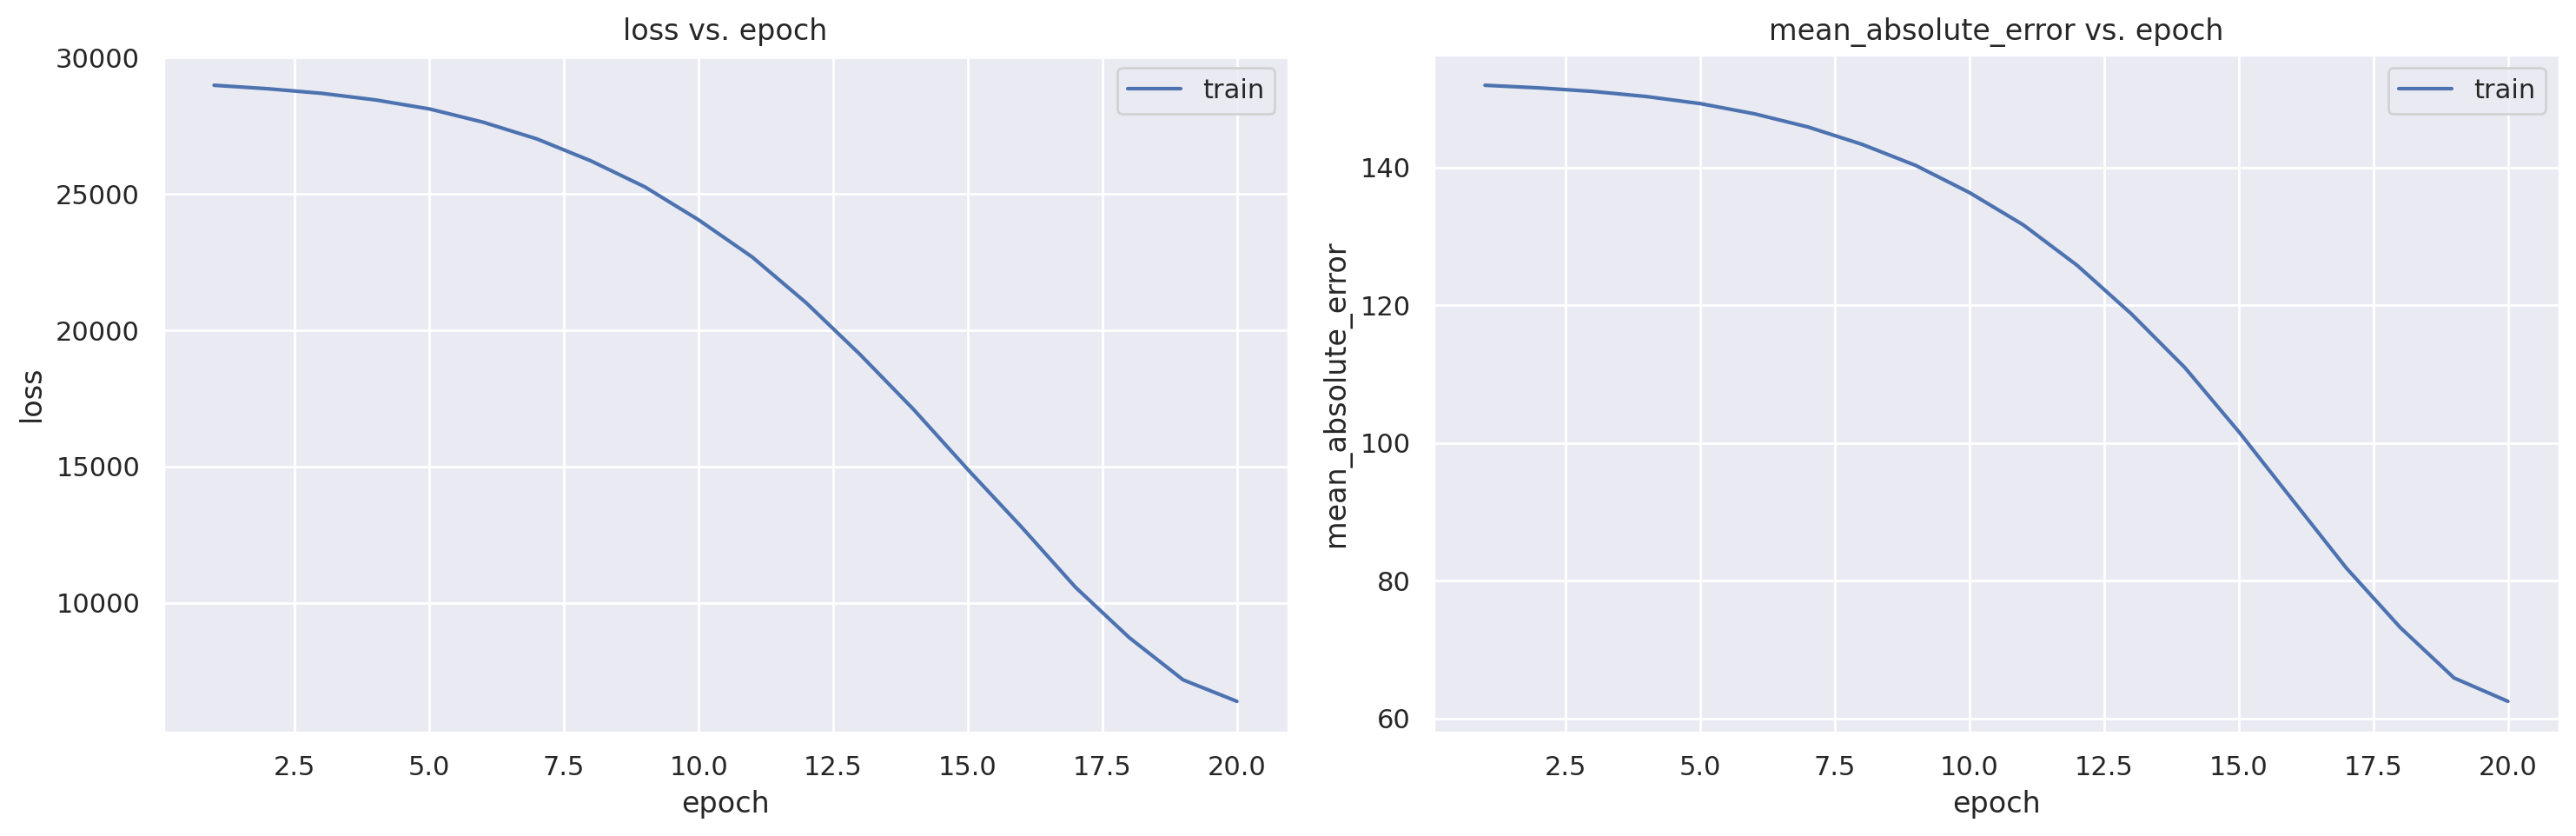

In [11]:
# Train the model
model = get_model(input_shape=(train_data.shape[1],))
history = model.fit(train_data, train_targets,
    epochs=20, batch_size=100, verbose=0,
    callbacks=[LossAndMetricCallback()])

# Plot training history
PlotHistory(history, metrics=['loss', 'mean_absolute_error']).plot()

We can also use our callback in the `evaluate` function...

In [14]:
# Evaluate the model
test_loss, test_mae = model.evaluate(test_data, test_targets, 
    batch_size=10, verbose=0,
    callbacks=[LossAndMetricCallback()])
print(f"test loss: {test_loss:.3f}, test mae: {test_mae:.3f}")


 After batch 0, the loss is 19266.82.

 After batch 1, the loss is 25086.17.

 After batch 2, the loss is 23511.93.

 After batch 3, the loss is 20449.28.

 After batch 4, the loss is 19179.52.
test loss: 19179.518, test mae: 120.852


...And also the `predict` function.

In [17]:
# Get predictions from the model
preds = model.predict(test_data,
    batch_size=10, verbose=0,
    callbacks=[LossAndMetricCallback()])
print(f"predictions: {np.squeeze(preds)}")

Finished prediction on batch 0!
Finished prediction on batch 1!
Finished prediction on batch 2!
Finished prediction on batch 3!
Finished prediction on batch 4!
predictions: [37.46809   29.294336  39.430542  71.33249   27.640486  12.2606125
 60.717903  52.23402   14.883112  12.704983  15.936214  13.095034
 25.07367   56.92909   11.743105  12.253832  59.449722  65.36003
 21.170124  57.043278  26.178469  13.643803  19.664764  51.33892
 13.621657  38.40045   44.59484   41.85211   24.50043   23.140026
 39.066982  18.101568  21.105265  48.05563   46.62981   43.214565
 18.201902  26.933563  46.21578   20.813166  17.049812  12.556177
 24.30646   47.245827  34.18916  ]


### Application - learning rate scheduler
Let's now look at a more sophisticated custom callback.

We are going to define a callback to change the learning rate of the optimiser of a model during training. We will do this by specifying the epochs and new learning rates where we would like it to be changed.

First we define the auxillary function that returns the learning rate for each epoch based on our schedule.

In [18]:
# Define the learning rate schedule. The tuples below are 
# (start_epoch, new_learning_rate)
lr_schedule = [(4, 0.03), (7, 0.02), (11, 0.005), (15, 0.007)]

def get_new_epoch_lr(epoch, lr):
    # Checks to see if the input epoch is listed in the learning rate
    # schedule and if so, returns index in lr_schedule
    epoch_in_sched = [i for i in range(len(lr_schedule)) 
        if lr_schedule[i][0]==int(epoch)]
    if len(epoch_in_sched)>0:
        # If it is, return the learning rate corresponding to the epoch
        return lr_schedule[epoch_in_sched[0]][1]
    else:
        # Otherwise, return the existing learning rate
        return lr

Let's now define the callback itself.

In [19]:
# Define the custom callback
class LRScheduler(tf.keras.callbacks.Callback):
    
    def __init__(self, new_lr):
        super().__init__()
        # Add the new learning rate function to our callback
        self.new_lr = new_lr
        
    def on_epoch_begin(self, epoch, logs=None):
        # Make sure that the optimizer we have chosen has a learning
        # rate, and raise an error if not
        if not hasattr(self.model.optimizer, 'lr'):
            raise ValueError("Error: Optimizer does not have a learning rate.")
            
        # Get the current learning rate
        curr_rate = float(tf.keras.backend.get_value(
            self.model.optimizer.lr))
        
        # Call the auxillary function to get the scheduled learning rate 
        # for the current epoch
        scheduled_rate = self.new_lr(epoch, curr_rate)
        
        # Set the learning rate to the scheduled learning rate
        tf.keras.backend.set_value(
            self.model.optimizer.lr, scheduled_rate)
        print("Learning rate for epoch {} is {:7.3f}".format(
            epoch, scheduled_rate))

Let's now train the model again with our new callback

Learning rate for epoch 0 is   0.001
Learning rate for epoch 1 is   0.001
Learning rate for epoch 2 is   0.001
Learning rate for epoch 3 is   0.001
Learning rate for epoch 4 is   0.030
Learning rate for epoch 5 is   0.030
Learning rate for epoch 6 is   0.030
Learning rate for epoch 7 is   0.020
Learning rate for epoch 8 is   0.020
Learning rate for epoch 9 is   0.020
Learning rate for epoch 10 is   0.020
Learning rate for epoch 11 is   0.005
Learning rate for epoch 12 is   0.005
Learning rate for epoch 13 is   0.005
Learning rate for epoch 14 is   0.005
Learning rate for epoch 15 is   0.007
Learning rate for epoch 16 is   0.007
Learning rate for epoch 17 is   0.007
Learning rate for epoch 18 is   0.007
Learning rate for epoch 19 is   0.007


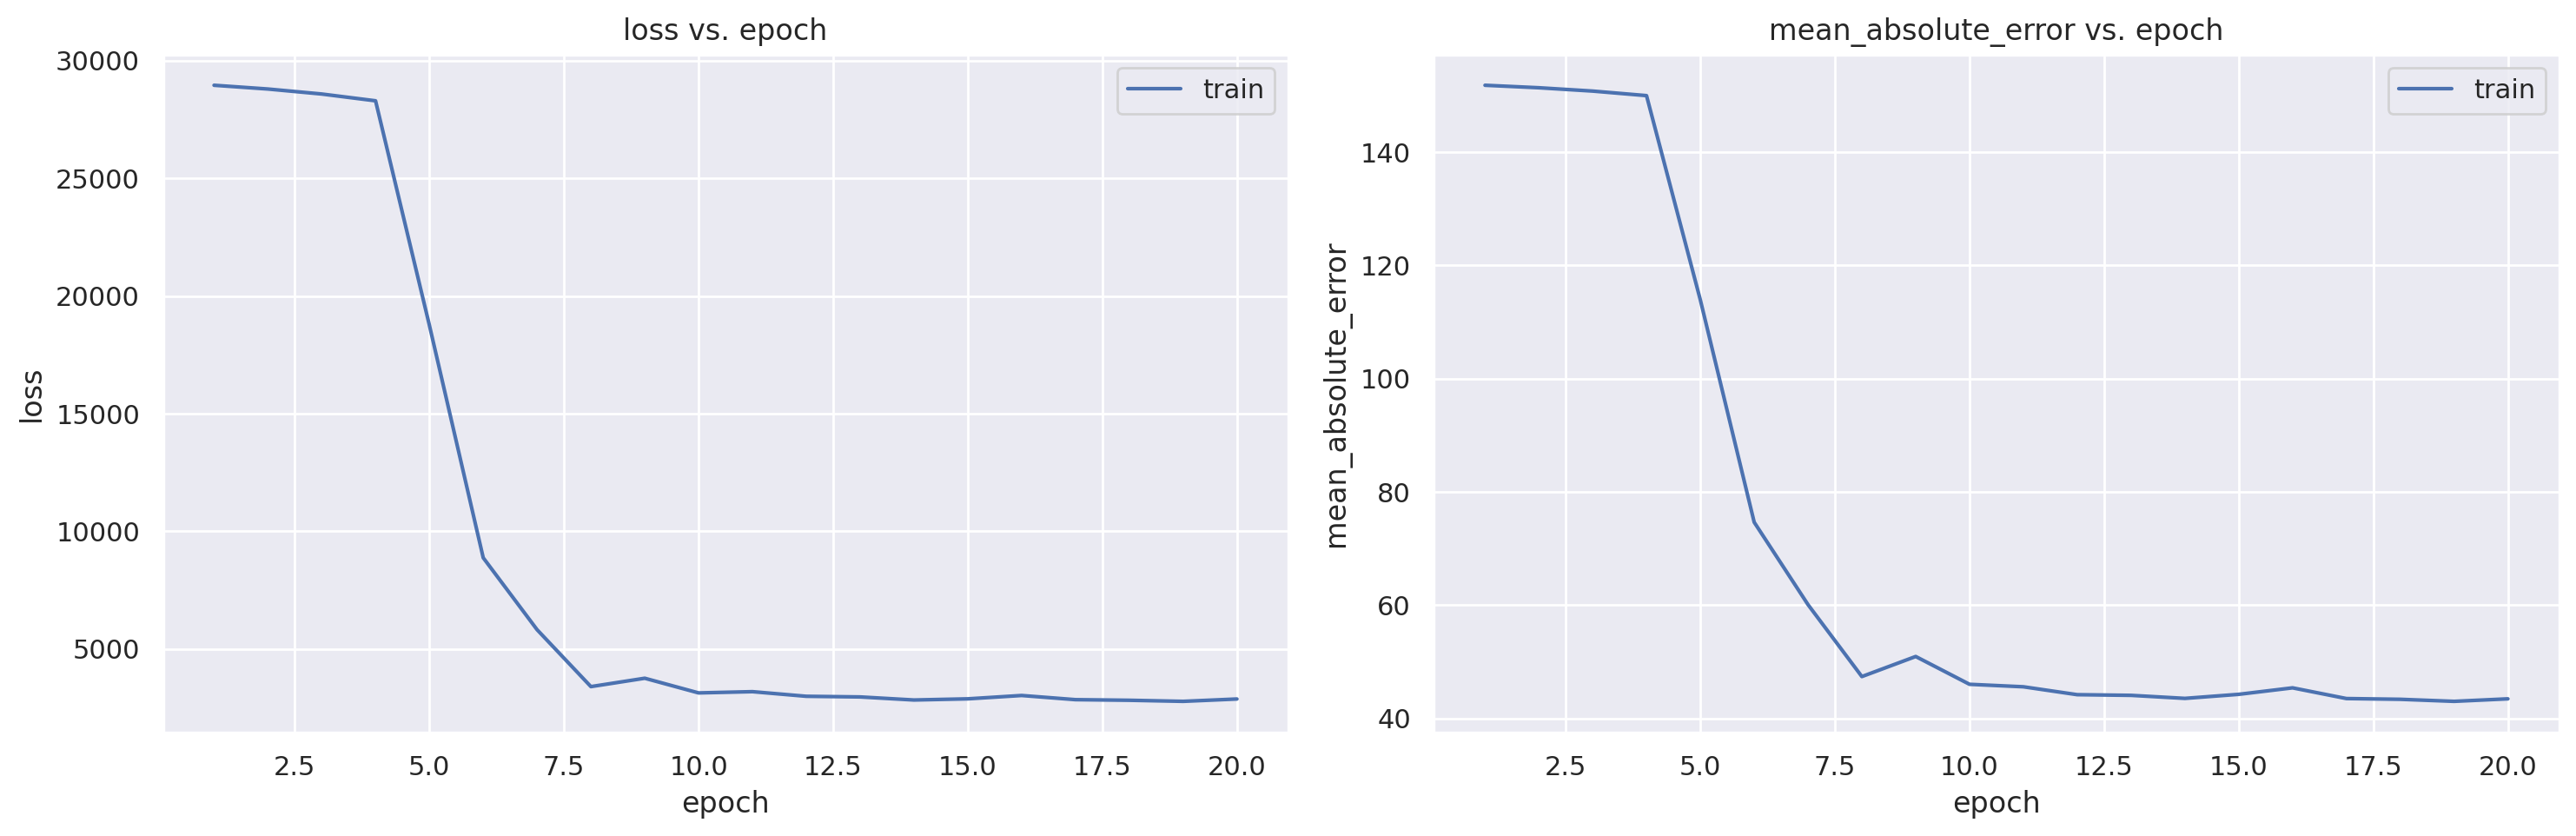

In [22]:
# Fit the model with our learning rate scheduler callback
model = get_model(input_shape=(train_data.shape[1],))
new_history = model.fit(train_data, train_targets,
    epochs=20, batch_size=100, verbose=0,
    callbacks=[LRScheduler(get_new_epoch_lr)])

# Plot training history
PlotHistory(new_history, metrics=['loss', 'mean_absolute_error']).plot()

### Further reading and resources
* https://www.tensorflow.org/guide/keras/custom_callback
* https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/Callback